In [2]:
import torch
%matplotlib inline
from matplotlib import pyplot

import combining_data.analysis_data
import noduleAnalysis.model

In [3]:
ds = combining_data.analysis_data.MalignantLunaDataset(val_stride=10, isValSet_bool=True)  # <1>
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])  # <2>
diam  = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()  # <3>
num_ben = len(is_mal) - num_mal

2022-06-03 15:54:05,125 INFO     pid:13284 combining_data.analysis_data:316:__init__ <combining_data.analysis_data.MalignantLunaDataset object at 0x0000028447A63BE0>: 6312 validation samples, 6301 neg, 11 pos, unbalanced ratio


In [5]:
threshold = torch.linspace(diam.max(), diam.min(), steps=5)

In [6]:
predictions = (diam[None] >= threshold[:, None])  # <1>
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal  # <2>
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [7]:
fp_diam_diff =  fp_diam[1:] - fp_diam[:-1]
tp_diam_avg  = (tp_diam[1:] + tp_diam[:-1])/2
auc_diam = (fp_diam_diff * tp_diam_avg).sum()

In [8]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

print(threshold)
print(fp_diam)
print(tp_diam)

tensor([19.6539, 15.9198, 12.1856,  8.4515,  4.7174])
tensor([0.0000, 0.0000, 0.1667, 0.3333, 1.0000])
tensor([0.2000, 0.4000, 0.6000, 0.8000, 1.0000])


In [9]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(19.6539) tensor(0.) tensor(0.2000)
1 tensor(15.9198) tensor(0.) tensor(0.4000)
2 tensor(12.1856) tensor(0.1667) tensor(0.6000)
3 tensor(8.4515) tensor(0.3333) tensor(0.8000)
4 tensor(4.7174) tensor(1.) tensor(1.)


diam: 19.65, x: 0.0, y: 0.2
diam: 4.72, x: 1.0, y: 1.0


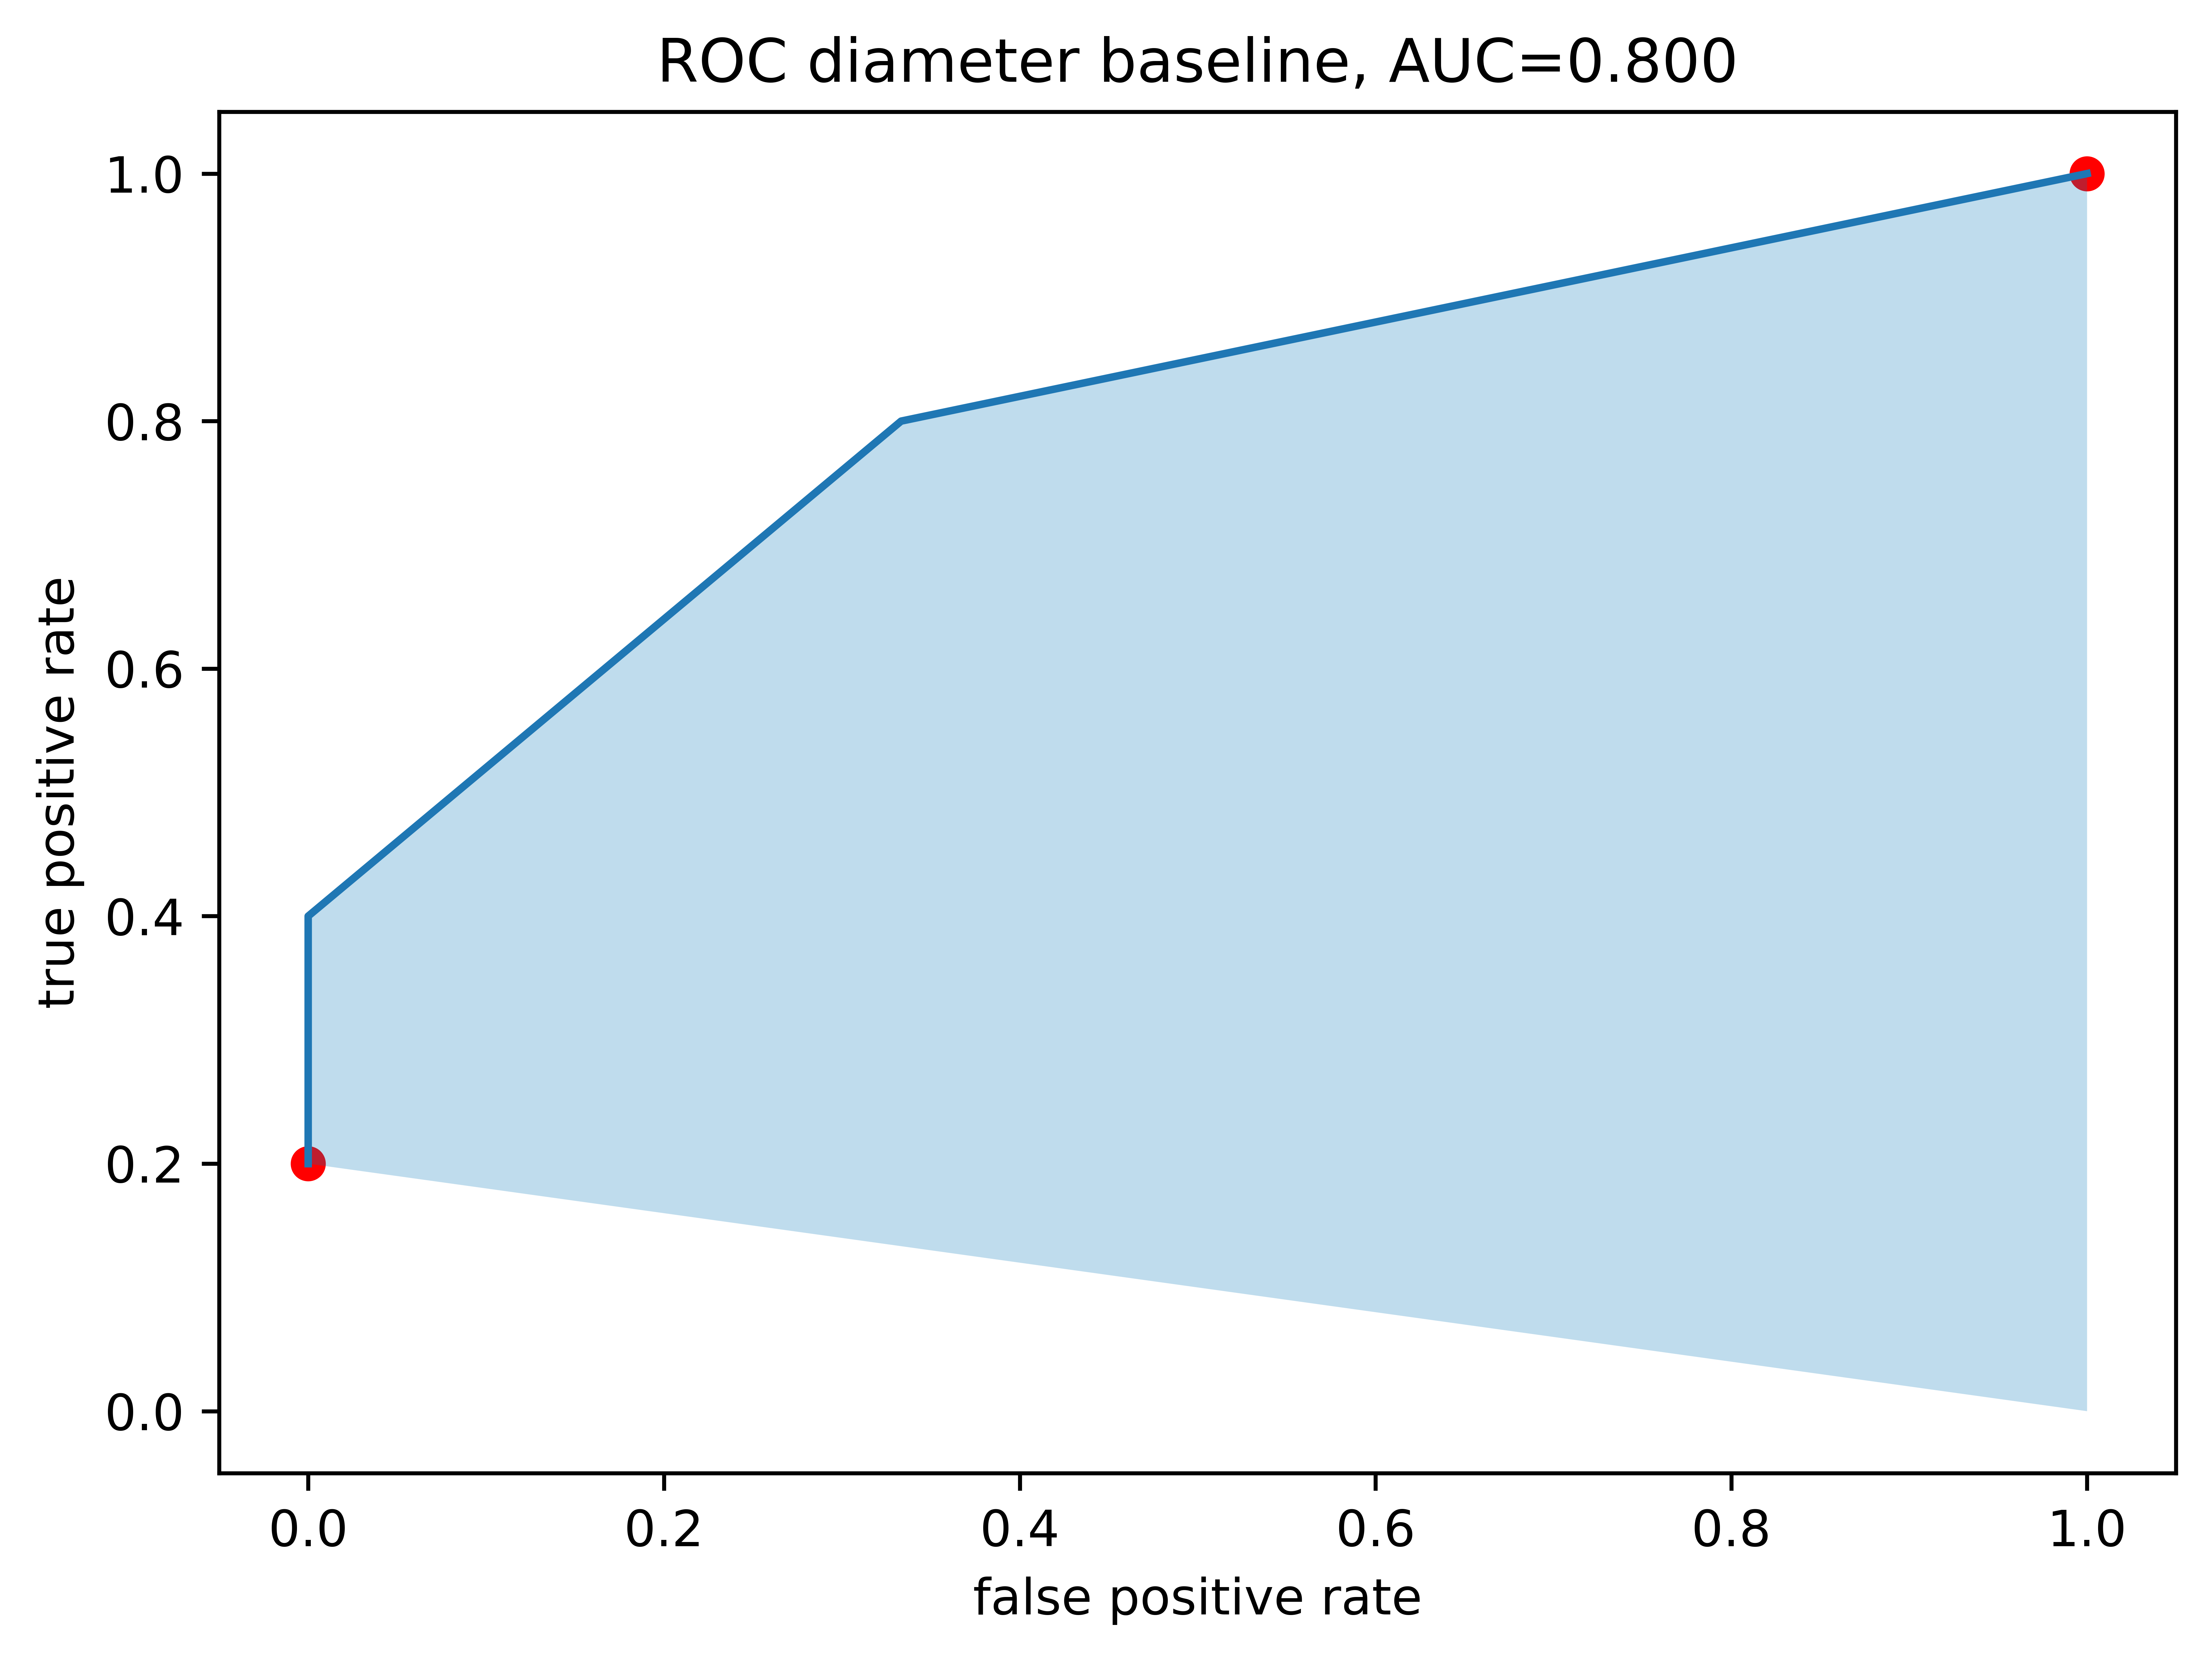

In [16]:
pyplot.figure(figsize=(7,5), dpi=1200)
for i in [0, 4]:
    pyplot.scatter(fp_diam[i], tp_diam[i], color='red')
    print(f'diam: {round(threshold[i].item(), 2)}, x: {round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}')
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.title(f'ROC diameter baseline, AUC={auc_diam:.3f}')
pyplot.ylabel('true positive rate')
pyplot.xlabel('false positive rate')
pyplot.savefig('roc_diameter_baseline.png')

In [20]:
model = noduleAnalysis.model.LunaModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sd = torch.load('data/models/NoduleAnalysis/mal_2022-06-03_14.11.24_finetune-head.best.state')
model.load_state_dict(sd['model_state'])
model.to(device)
model.eval();

In [21]:
ds = combining_data.analysis_data.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)

2022-06-03 16:01:08,275 INFO     pid:13284 combining_data.analysis_data:316:__init__ <combining_data.analysis_data.MalignantLunaDataset object at 0x000002845676DCA0>: 6312 validation samples, 6301 neg, 11 pos, unbalanced ratio


In [22]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

C:\Users\apoor\AppData\Local\Temp/ipykernel_13284/2703842758.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  pyplot.savefig('roc_finetune.png')


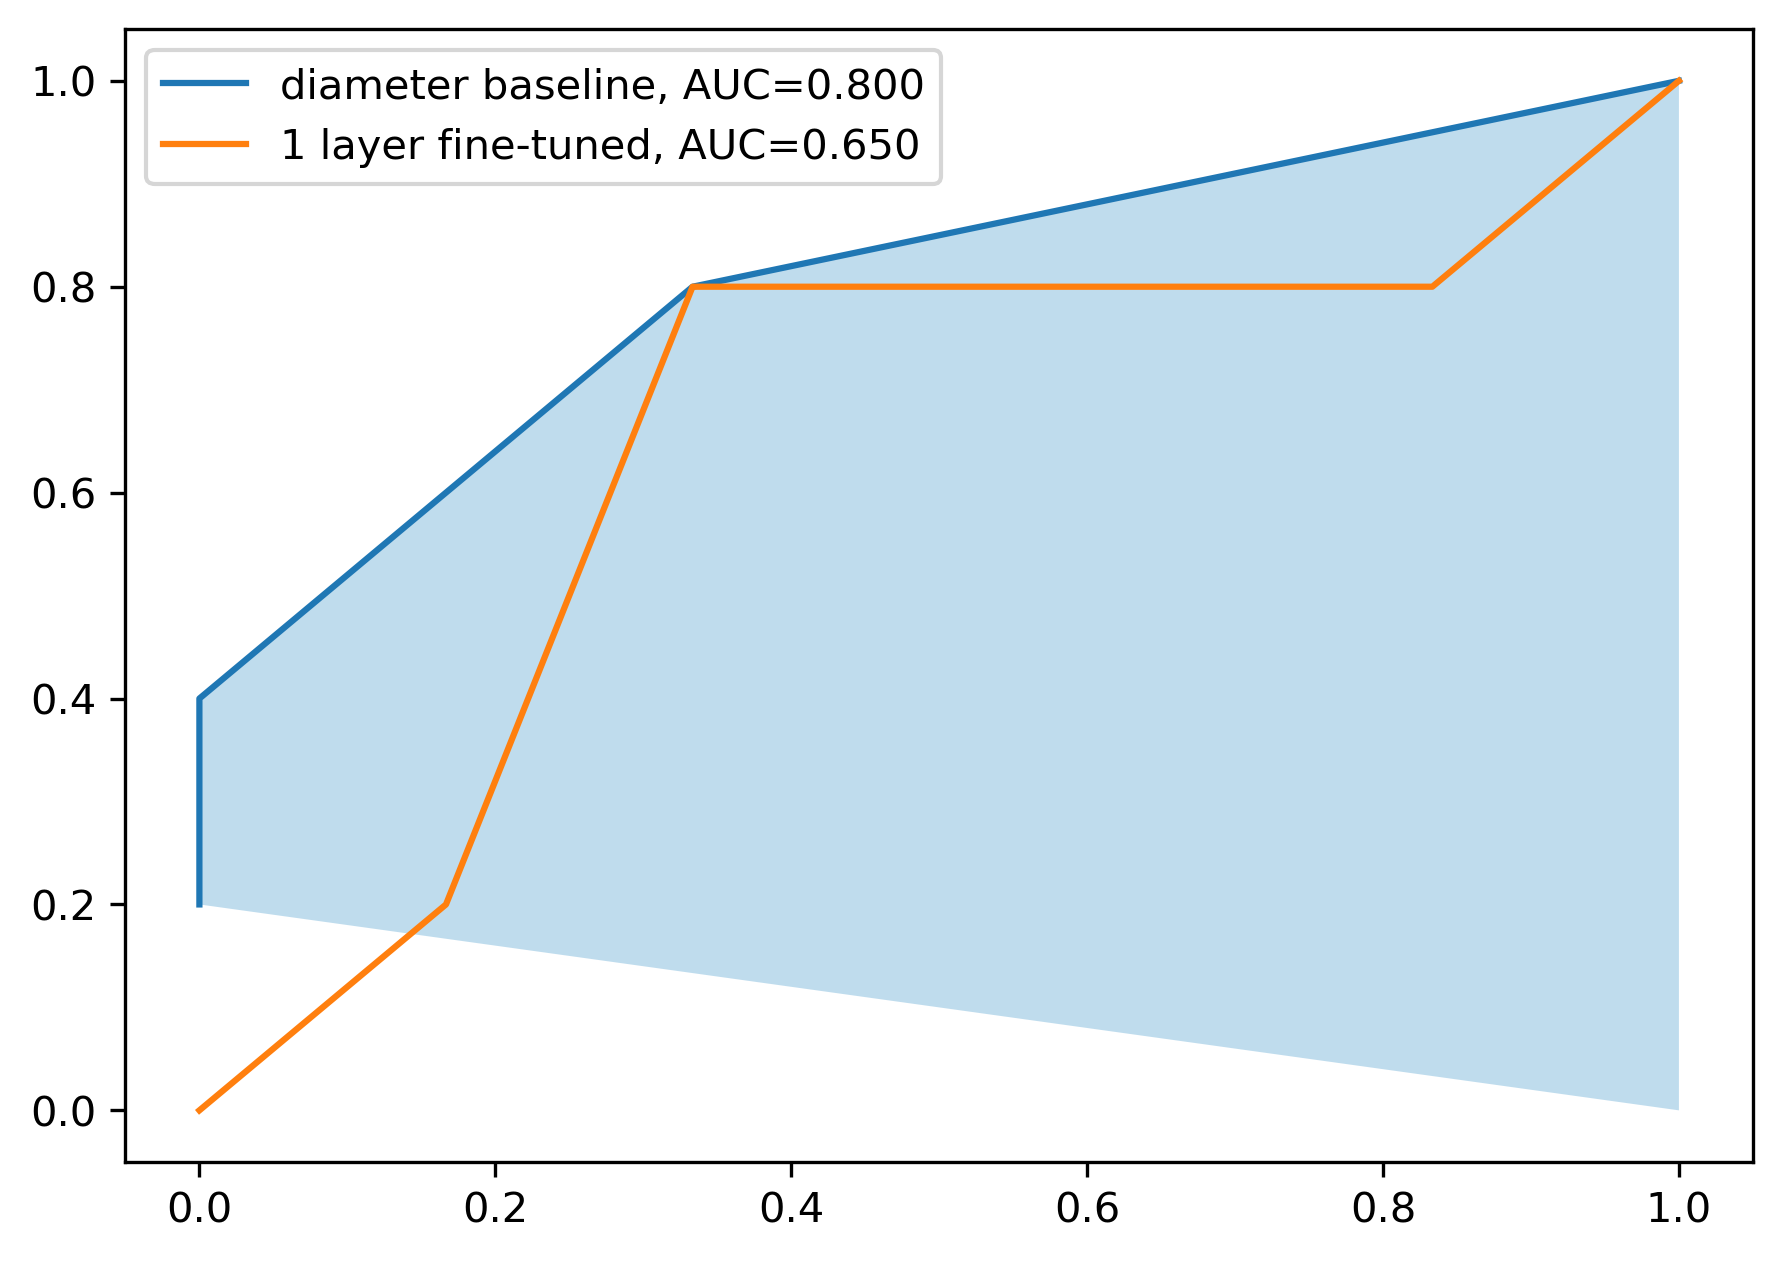

In [24]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps = 5)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben
fp_finetune_diff = fp_finetune[1:]-fp_finetune[:-1]
tp_finetune_avg  = (tp_finetune[1:]+tp_finetune[:-1])/2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.legend()
pyplot.savefig('roc_finetune.png')

In [26]:
if 1:
    fn = 'data/models/NoduleAnalysis/mal_2022-06-03_15.36.02_finetune-depth=2.best.state'
    model = noduleAnalysis.model.LunaModel()
    sd = torch.load(fn, map_location='cpu')['model_state']
    model.load_state_dict(sd)
    model.to(device)
    model.eval();

In [27]:
model.eval()
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)    
    truth += (label[:,1]>0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

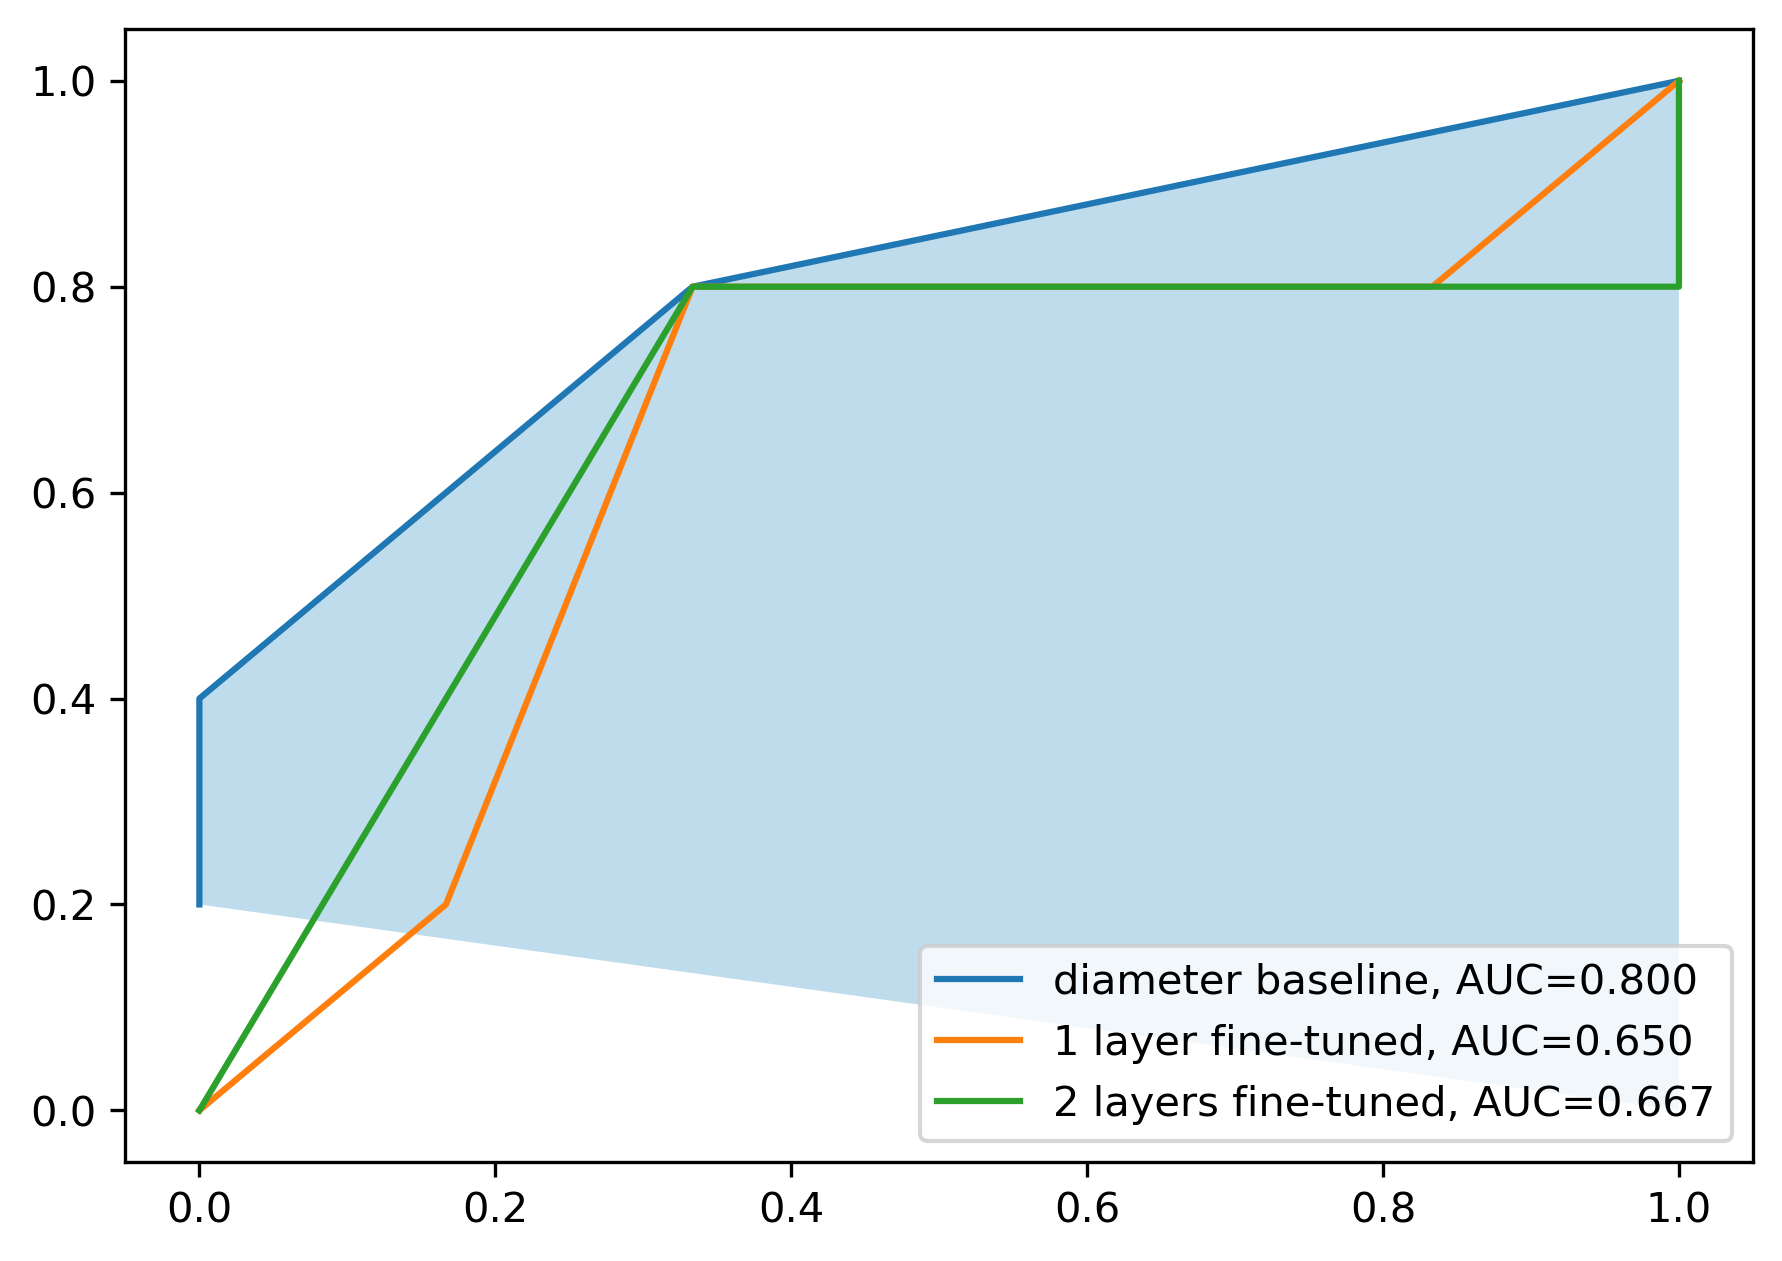

In [28]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, steps=5)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:]-fp[:-1]
tp_avg  = (tp[1:]+tp[:-1])/2
auc_modified = (fp_diff * tp_avg).sum()

pyplot.figure(figsize=(7,5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor='#0077bb', alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f'diameter baseline, AUC={auc_diam:.3f}')
pyplot.plot(fp_finetune, tp_finetune, label=f'1 layer fine-tuned, AUC={auc_finetune:.3f}')
pyplot.plot(fp, tp, label=f'2 layers fine-tuned, AUC={auc_modified:.3f}')
pyplot.legend()
pyplot.savefig('roc_modified.png')